# Overview

This notebook tackles the Rossmann Store Sales competition hosted by Kaggle back in 2015 (for detail see: https://www.kaggle.com/c/rossmann-store-sales) via using random forest. This is meant to be a practice utilizing the FastAI 0.7 framework along with Scikit-learn modules. The full dataset can be downloaded from: https://www.kaggle.com/c/4594/download-all.


### The Goal

The goal of this exercise was not to beat the state-of-the-art, but ***rather to do a very naive, but DAMN QUICK*** attempt at solving a timeseries prediction problem, ***with a little feature engineering as possible*** using the tools provided by FastAI(0.7) as taught in Jeremy Howards' Machine Learning MOOC. (These courses can be found here: https://course.fast.ai/ml.html. They're AWESOME and you should go through them!) 


### TLDR
We fitted a Random Forest Regressor on the dataset at achieved a RMSPE score of 0.13169 on the public score, and 0.143 on the private score on Kaggle leaderboard. This is by no means performance to be proud of, but with next to no feature engineering, this score ranked 2032 position out of 3253 teams on the private leader board. **Furthermore, it should be noted that this result did not utilize the additional supplementary datasets (ie. Google Trends dataset) that the winning solutions incorporated.**

In [1]:
# hack to sort out Module not found error associated with import fastai
import sys
sys.path.append("../fastai/old/") # go to parent dir

In [2]:
import numpy as np

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding
from IPython.display import display

from sklearn import metrics

---
# Dataset

In [3]:
DATA_DIR = "./dataset/"

# load datasets
train = pd.read_csv(f'{DATA_DIR}/train.csv', low_memory=False, parse_dates=['Date'])
test  = pd.read_csv(f'{DATA_DIR}/test.csv', low_memory=False, parse_dates=['Date'])
store = pd.read_csv(f'{DATA_DIR}/store.csv', low_memory=False)

In [4]:
# get a broader view of dataframe
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

The cell below shows the training dataset we have to work with - it lists the feature data we have on 1115 stores on each date within the study period.

- there are a total of 1,017,209 rows with 9 columns, one of which *Sales* is the target variable we will try to predict. 
- the training dataset spans from 2013-01-01 to 2015-07-31; and 
- the test dataset spans from 2015-08-01 to 2015-09-17.

### train dataset

- **Store**: a unique Id for each store
- **Sales**: the turnover for any given day (this is what you are predicting)
- **Customers**: the number of customers on a given day
- **Open**: an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday**: indicates if the (Store, Date) was affected by the closure of public schools
- **Promo**: indicates whether a store is running a promo on that day


In [5]:
# show dataset
display_all(train)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [6]:
# sort dataset into chronological order based on Date, then Store
train.sort_values(by=['Date','Store'], ascending=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [7]:
# remove samples where store is open but sales is 0 or negative 
# (since this makes no sense and there's no feature at our disposal to reasonable explain this)
train = train[~((train.Sales<=0)&(train.Open==1))]

In [8]:
print('columns present in train but not in test:')
for c in train.columns: 
    if c not in test.columns: print(c)

print('\ncolumns present in test but not in train:')
for c in test.columns: 
    if c not in train.columns: print(c)

columns present in train but not in test:
Sales
Customers

columns present in test but not in train:
Id


### customer feature

In [9]:
# compute correlation between sales and customers since customers is a good indicator of sales
train.Sales.corr(train.Customers)

0.8946997899355179

It can be noted that while *Customers* is evidentally and intuitively a powerful predictor of sales level, but it is really not a useful feature practically, since it is another problem in itself to predict the number of customers. Also note this is also absent in the test dataset. 

However, instead of throwing this feature away entirely, we could use *historical* mean, median, stdev customer levels from each store as a predictor. In order to do this, we first group the training dataset by *Store*. Within each sub-frame (of the same store), we compute the average, median, and standard deviation of customer levels on each date, based on *historical* (via shift 1) customers count.

In [10]:
def findCustomerStatsPriorTo(row, compute):
    # shift by one to ensure using historical data
    row['Customers'] = row.Customers.shift(1)
    # filter-out the days when store was closed or there was no customers
    row = row[(row.Open==1)&(row.Customers>0)]
    if compute=='avg':
        return row[['Date','Customers']].rolling(window=30, min_periods=1, on='Date', closed='right').mean()
    elif compute=='med':
        return row[['Date','Customers']].rolling(window=30, min_periods=1, on='Date', closed='right').median()
    elif compute=='std':
        return row[['Date','Customers']].rolling(window=30, min_periods=1, on='Date', closed='right').std()

In [11]:
avg_customers = train.groupby('Store').apply(lambda row: findCustomerStatsPriorTo(row, 'avg'))
med_customers = train.groupby('Store').apply(lambda row: findCustomerStatsPriorTo(row, 'med'))
std_customers = train.groupby('Store').apply(lambda row: findCustomerStatsPriorTo(row, 'std'))

In [12]:
def process(df, dropCol, cols):
    df.reset_index(inplace=True)
    df.drop(dropCol, axis=1, inplace=True)
    df.columns = cols
    return df

# clean stats dataframe
avg_customers = process(avg_customers, 'level_1', ['Store', 'Date', 'AvgCustomers'])
med_customers = process(med_customers, 'level_1', ['Store', 'Date', 'MedCustomers'])
std_customers = process(std_customers, 'level_1', ['Store', 'Date', 'StdCustomers'])

# merge all stats together
store_customer_stat = avg_customers.merge(med_customers, on=['Store','Date'], how='left').\
                                    merge(std_customers, on=['Store','Date'], how='left')

In [13]:
# one-line code to examine the % of values being null for all features
display_all(store_customer_stat.isnull().sum().sort_index()/len(store_customer_stat))

AvgCustomers    0.000000
Date            0.000000
MedCustomers    0.000000
StdCustomers    0.001633
Store           0.000000
dtype: float64

And so we have the customer level stats at each store at each date - based on historical customers data from the past 30 days. We will apply this information to the training and testing dataset, for each store, on each date, leveraging the latest customer stats information available on the date.

In [14]:
# join lastest available date of customer stats with train dataset
train = train.merge(store_customer_stat, on=['Store','Date'], how='left')

In [15]:
# join lastest available date of customer stats with test dataset
tmp = store_customer_stat[store_customer_stat.Date==store_customer_stat.Date.max()]\
      [[c for c in store_customer_stat.columns if c!='Date']]
test = test.merge(tmp, on=['Store'], how='left')

### store dataset

- **StoreType**: differentiates between 4 different store models: a, b, c, d
- **Assortment**: describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistanc**: distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]**: gives the approximate year and month of the time the nearest competitor was opened
- **Promo2**: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]**: describes the year and calendar week when the store started participating in Promo2
- **PromoInterval**: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [16]:
display_all(store)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


### join dataset

It is clear that the store dataset is relational to both train and test dataset since it gives additional information about the store. Let's join the train/test dataset with the store dataset.

In [17]:
# join the store information with train/test datasets
train = train.merge(right=store, on='Store', how='left')
test = test.merge(right=store, on='Store', how='left')

### validation datset

Before proceeding further, we will construct a separate validation dataset that we will use to gauge our models' performance in the absence of test dataset sales data (you only find out the model performance on test dataset after submitting your result to Kaggle). 

We know that the test datset spans approximately 1.5 month from 2015-08-01 to 2015-09-17 (approx. 40,000 rows). While the train dataset spans from 2013-01-01 to 2015-07-31. As a result, it is much more reasonable to carve out the last 1.5 month from the train dataset (under the understanding that the train dataset was sorted in ascending chronological order) and reserve them as validation (as opposed to randomly sampling from various days). This allows us to gauge our models' ability to predict the *future* based on data seen of the past.

In [18]:
# compute the last N days of train to reserve as validation (such that validation is approx same size as test)
n_days = math.ceil(test.shape[0]/train.Store.nunique())
# determine the cutoff_date to use for splitting dataset
cutoff_date = train.tail(1).Date.values[0] - np.timedelta64(n_days, 'D')
print('dates before {} will be for training; those on & after reserved for validation'.format(cutoff_date))

dates before 2015-06-24T00:00:00.000000000 will be for training; those on & after reserved for validation


In [19]:
df_raw = train[train.Date<cutoff_date].copy()
df_val = train[train.Date>=cutoff_date].copy()

In [20]:
print('train shape: ', df_raw.shape, ';\nvalidation shape: ', df_val.shape, ';\ntest shape: ', test.shape)

train shape:  (974785, 21) ;
validation shape:  (42370, 21) ;
test shape:  (41088, 20)


### expand date column

We notice that we can get additional features from the *Date* column by creating *Year, Month, Week, Day, etc*. This can be easily done via *fastai*'s `add_datepart` function, which takes the specified date column, expands it to all ancilliary columns and removes the original date column.

In [21]:
# expand date column
add_datepart(df_raw, 'Date')
add_datepart(df_val, 'Date')
add_datepart(test, 'Date')

In [22]:
display_all(df_raw)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,AvgCustomers,MedCustomers,StdCustomers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,2,0,0,0,0,a,1,NaN,NaN,NaN,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,2,2,0,0,0,0,a,1,NaN,NaN,NaN,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
2,3,2,0,0,0,0,a,1,NaN,NaN,NaN,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
3,4,2,0,0,0,0,a,1,NaN,NaN,NaN,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
4,5,2,0,0,0,0,a,1,NaN,NaN,NaN,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
5,6,2,0,0,0,0,a,1,NaN,NaN,NaN,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
6,7,2,0,0,0,0,a,1,NaN,NaN,NaN,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
7,8,2,0,0,0,0,a,1,NaN,NaN,NaN,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
8,9,2,0,0,0,0,a,1,NaN,NaN,NaN,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
9,10,2,0,0,0,0,a,1,NaN,NaN,NaN,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400


### categorical features

Notice that the *PromoInterval* feature is of type string, we will treat this as categorical variable. Furthermore,  we checked to see that both train/test datasets contained the exact same range of categories as shown below. It looks like there are three types of promo intervals, aside from not have a promo.

In [23]:
print('train PromoInterval distinct values: ',train.PromoInterval.unique().tolist())
print('test PromoInterval distinct values: ',test.PromoInterval.unique().tolist())

train PromoInterval distinct values:  [nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']
test PromoInterval distinct values:  [nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']


Once again, we will leverage fastai's `train_cats` function that converts any string features (or of type `object`) into categorical values. The `apply_cats` function was then applied onto the test dataset to ensure consistent categorical mapping.

In [24]:
# convert columns of type object to categorical representation
train_cats(df_raw)
# apply categorical mapping onto validation/test, based on train
apply_cats(df_val, df_raw)
apply_cats(test, df_raw)

In [25]:
# check for type consistency
for c in df_raw.columns:
    print(c, df_raw[c].dtype)

Store int64
DayOfWeek int64
Sales int64
Customers int64
Open int64
Promo int64
StateHoliday category
SchoolHoliday int64
AvgCustomers float64
MedCustomers float64
StdCustomers float64
StoreType category
Assortment category
CompetitionDistance float64
CompetitionOpenSinceMonth float64
CompetitionOpenSinceYear float64
Promo2 int64
Promo2SinceWeek float64
Promo2SinceYear float64
PromoInterval category
Year int64
Month int64
Week int64
Day int64
Dayofweek int64
Dayofyear int64
Is_month_end bool
Is_month_start bool
Is_quarter_end bool
Is_quarter_start bool
Is_year_end bool
Is_year_start bool
Elapsed int64


Everything looks good!

### check for NaN

Below, we use this handy one-liner to look at the percentage of rows having NaN value.

In [26]:
# one-line code to examine the % of values being null for all features
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Assortment                   0.000000
AvgCustomers                 0.331949
CompetitionDistance          0.002593
CompetitionOpenSinceMonth    0.317893
CompetitionOpenSinceYear     0.317893
Customers                    0.000000
Day                          0.000000
DayOfWeek                    0.000000
Dayofweek                    0.000000
Dayofyear                    0.000000
Elapsed                      0.000000
Is_month_end                 0.000000
Is_month_start               0.000000
Is_quarter_end               0.000000
Is_quarter_start             0.000000
Is_year_end                  0.000000
Is_year_start                0.000000
MedCustomers                 0.331949
Month                        0.000000
Open                         0.000000
Promo                        0.000000
Promo2                       0.000000
Promo2SinceWeek              0.499950
Promo2SinceYear              0.499950
PromoInterval                0.499950
Sales                        0.000000
SchoolHolida

The features exhibiting large portion of `NaN` values are related to *Promo2Since\**, which contains the NaN as a category in itself. The *CompetitionOpenSince\** and customer stats-related features also contains some `NaN` values. We will handle these next by filling them with median values.

### process dataframe

Here again, we leverage fastai's `proc_df` convenience function to turn our datasets into complete numeric format; ready for model fitting!

In [27]:
df_raw.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,AvgCustomers,MedCustomers,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,2,0,0,0,0,a,1,NaN,NaN,...,1,1,1,False,True,False,True,False,True,1356998400
1,2,2,0,0,0,0,a,1,NaN,NaN,...,1,1,1,False,True,False,True,False,True,1356998400
2,3,2,0,0,0,0,a,1,NaN,NaN,...,1,1,1,False,True,False,True,False,True,1356998400


In [34]:
# 1-liner to convert dataframe to numeric (ready for .fit!)
# note: we will be removing "Customers" field because we created proxies for it with AvgCustomers, MedCustomers, StdCustomers
#       we will remove "DayOfWeek" since it overlaps with "Dayofweek" created during add_datepart
col2rmv = ['Customers','DayOfWeek']

X_train, y_train, nas_train = proc_df(df=df_raw, y_fld='Sales', skip_flds=col2rmv, do_scale=False, max_n_cat=10)

In [35]:
# note that those feature rows with NaN values are replaced by their median values
# these median values are recorded in nas_train
nas_train

{'AvgCustomers': 699.4333333333333,
 'MedCustomers': 686.5,
 'StdCustomers': 108.12691563647557,
 'CompetitionDistance': 2330.0,
 'CompetitionOpenSinceMonth': 8.0,
 'CompetitionOpenSinceYear': 2010.0,
 'Promo2SinceWeek': 22.0,
 'Promo2SinceYear': 2012.0}

In [37]:
# apply same processing to validation and test datset 
# note that we supply the nas_train such that the fillna function 
# is using the same set of feature median values derived from training datset
X_valid, y_valid, nas_valid = proc_df(df=df_val, y_fld='Sales', skip_flds=col2rmv, do_scale=False, max_n_cat=10, na_dict=nas_train)
X_test, _, nas_test = proc_df(df=test, y_fld=None, skip_flds=['DayOfWeek','Id'], do_scale=False, max_n_cat=10, na_dict=nas_train)

In [38]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(974785, 52)
(42370, 52)
(41088, 52)


### preserve processed dataset

Here, we will use the lightweight feather format to save our processed datasets such that they can be loaded quickly next time without running through the codes all over again.

In [44]:
# feather does not support serializing a non-default index for the index
X_valid.reset_index(drop=True, inplace=True)

In [45]:
# saves dataframe to feather format
os.makedirs('./processed', exist_ok=True)
X_train.to_feather('./processed/X_train')
X_valid.to_feather('./processed/X_valid')
X_test.to_feather('./processed/X_test')

In [46]:
import feather 

# to load data from feather
X_train = feather.read_dataframe('./processed/X_train')
X_valid = feather.read_dataframe('./processed/X_valid')
X_test  = feather.read_dataframe('./processed/X_test')

---
# Feature Importance

We will fit an out-of-the-box random forest regressor to help us examine feature importance. To speed up the process, we will be working on a subset of the training dataset.

In [47]:
X_smp = X_train.sample(frac=0.1, random_state=10).copy()
y_smp = y_train[X_smp.index]

In [48]:
# Evaluation is based on Root Mean Square Percentage Error (RMSPE)
def rmspe(x,y): 
    non_zero_idx = y.nonzero()
    x = x[non_zero_idx]
    y = y[non_zero_idx]    
    return math.sqrt((((x-y)/y)**2).mean())

def print_score(m):
    labels = ['rmspe(train)', 'rmspe(valid) ', 'r2(train)   ', 'r2(valid)    ']
    res = [rmspe(m.predict(X_train), y_train),  # score on train dataset
           rmspe(m.predict(X_valid), y_valid),  # score on valid dataset
           m.score(X_train, y_train),          # R^2 on train dataset
           m.score(X_valid, y_valid)]          # R^2 on valid dataset
    # append out-of-batch score if available
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    for label, score in zip(labels, res):
        print('{}: {}'.format(label, score))

In [49]:
# directly fit a RF (with default settings) & compute R2 score
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)  # n_jobs=-1 utilizes all available CPUs
m.fit(X_smp, y_smp)
print_score(m)

rmspe(train): 0.24303142913978681
rmspe(valid) : 0.2083409222289634
r2(train)   : 0.9098149816395129
r2(valid)    : 0.8731014416485846


The result is already quite good out of the box!! Now let's take a look at the feature importance (computed by iteratively shuffle each feature out-of-order to destroy the information and examine how much effect it has on the performance). 

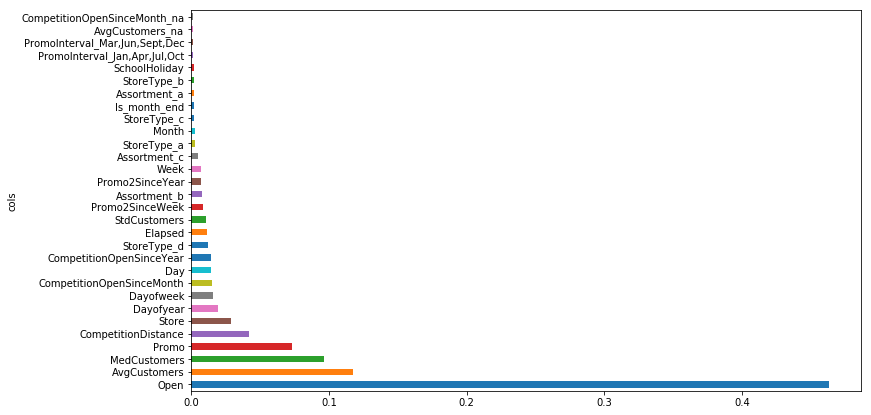

In [50]:
# compute feature importance
fi = rf_feat_importance(m, X_train)

# function for visualizing feature importance
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

# plot top-30 feature importance
plot_fi(fi[:30]);

It can be seen that feature importance is dominated by the *Open* feature. This is obvious since if the store is closed, then there wouldn't be sales. The next important features are the *AvgCustomers* and *MedCustomers* features we created earlier. This also makes sense since the customer level is highly correlated with sales.

Let's view the same plot without the *Open* feature to provide better contrast on other feature importances.

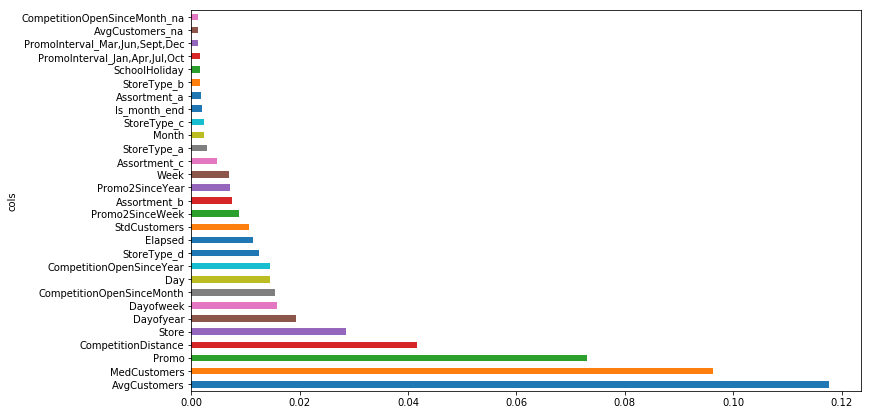

In [51]:
# plot top-30 feature importance; without Open
plot_fi(fi[1:30]);

let's trim out some of the less important features...

In [56]:
# trim out features based on importance threshold
to_keep = fi[fi.imp>0.005].cols;

print(to_keep)

1                          Open
4                  AvgCustomers
5                  MedCustomers
2                         Promo
7           CompetitionDistance
0                         Store
18                    Dayofyear
17                    Dayofweek
8     CompetitionOpenSinceMonth
16                          Day
9      CompetitionOpenSinceYear
42                  StoreType_d
25                      Elapsed
6                  StdCustomers
11              Promo2SinceWeek
45                 Assortment_b
12              Promo2SinceYear
15                         Week
Name: cols, dtype: object


In [58]:
# update feature set
X_train = X_train[to_keep]
X_valid = X_valid[to_keep]
X_test  = X_test[to_keep]

In [59]:
# let's get a baseline measurement on the feature-trimmed dataset, 
# fitted on the entire training dataset
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)  # n_jobs=-1 utilizes all available CPUs
m.fit(X_train, y_train)
print_score(m)

rmspe(train): 0.09004118720856404
rmspe(valid) : 0.15896616756552942
r2(train)   : 0.9897022762531371
r2(valid)    : 0.9259609775934365


From the above, we can see our performance improved significantly from previously since we now trained on all available training dataset. We can also see that our training performance is quite a bit better than the validation performance. HoweverThis shows sign of overfitting. Next, we will tune the h-parameters in our RF model to overcome this.

---
# H-param Tunning

### selecting N estimators (trees)

In [85]:
# fit each RF tree using random subset of dataset
set_rf_samples(20000)

In [69]:
# use parallel_trees for parallel computation
def get_preds(t): return t.predict(X_valid)

m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
preds = np.stack(parallel_trees(m, get_preds))

Text(0,0.5,'R^2 score')

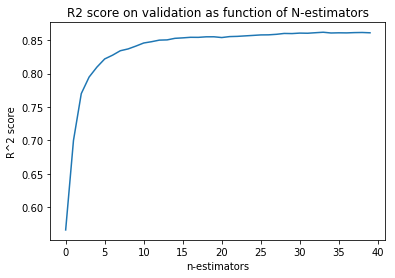

In [74]:
# show how score varies with number of estimators
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);
plt.title('R2 score on validation as function of N-estimators')
plt.xlabel('n-estimators')
plt.ylabel('R^2 score')

From the plot above, we see that the elbow occurrs around 5-estimators, beyond which the $R^2$ improvement quickly deteriorates. Based on this diagram, we will select `n_estimators=20` to give some additional estimators for combatting overfitting.

In [88]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

rmspe(train): 0.2959010294419199
rmspe(valid) : 0.23729453430580444
r2(train)   : 0.8734953122649217
r2(valid)    : 0.855303985345772


### selecting max_features / min_samples_leaf

The overfitting situation seems to have improved slightly! Let's see if we can improve things further by randomly selecting a subset of features for each estimator, as well as limiting the minimum number of samples at each leaf node.

In [100]:
m = RandomForestRegressor(n_estimators=20, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

rmspe(train): 0.3045599618334343
rmspe(valid) : 0.2391322913359482
r2(train)   : 0.8691600400053671
r2(valid)    : 0.8518130642978543


In [104]:
m = RandomForestRegressor(n_estimators=20, max_features=0.5, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

rmspe(train): 0.30861160023751644
rmspe(valid) : 0.2338490176980621
r2(train)   : 0.8622035803462098
r2(valid)    : 0.8515971719457223


From the above, sub-sampling features appeared to help with improving the R2 error gap between train/validation. Increasing the `min_samples_leaf` parameter appeared to cause some further minor improvements, but we'll take it!

In [108]:
# turn off RF sampling
reset_rf_samples()

# fit on the entire dataset
m = RandomForestRegressor(n_estimators=20, max_features=0.5, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

rmspe(train): 0.1537886366380225
rmspe(valid) : 0.14109276314881145
r2(train)   : 0.976565178721361
r2(valid)    : 0.9400495112109599


After tunning the h-params, the performance gap between the training and validation dataset have shrunk to quite a reasonable range, and it indicates major performance from the previous out-of-the-box fitting which indicated RMSPE of 0.09 on training, but 0.158 on validation. Based on this measurement (and if our validation dataset is representative of the test dataset), we can reasonably expect an RMSPE measure of approx. 14-15% on the test dataset.

---
# Fit on entire dataset

Finally, let's leverage the entire dataset (combinning both training and validation datasets) to fit our final RF regressor model.

In [129]:
X = X_train.append(X_valid, ignore_index=True)
y = np.concatenate((y_train, y_valid))

In [ ]:
# fit on the entire dataset (train + valid)
m = RandomForestRegressor(n_estimators=20, max_features=0.5, min_samples_leaf=3, n_jobs=-1)
m.fit(X, y)

In [178]:
# prediction on the test dataset
y_test_prediction = m.predict(X_test)

# add prediction column to dataframe
test['Sales'] = y_test_prediction

In [185]:
# create submission csv file
submission = test[['Id','Sales']]
submission.to_csv(f'{DATA_DIR}/submission.csv', index=False)

After submitting the test dataset prediction to Kaggle for scoring, we received a 0.13169 score on the public score, and 0.143 on the prive score. This is very close to our expectation based on our validation dataset.

<img src="submission_screenshot.png">

<img src="score.png">